In [7]:
from utils_cv import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import cv2
import collections
import time
from skimage import io
from skimage.feature import canny
from skimage.transform import rescale
from skimage.morphology import dilation, disk
import scipy 
import skimage
from skimage import img_as_ubyte

import pandas as pd
from IPython.display import Image as Image_print


from scipy.spatial import distance as dist
from imutils import perspective
from imutils import contours
import imutils

# from tqdm import tqdm_notebook as tqdm
from ipypb import ipb as tqdm


import time

%matplotlib inline

from IPython import display

from scipy.ndimage import distance_transform_edt

1. Problem description. 8 points

Why is it important (innovation / research / fun)?
What's the expected value of your CV algorithm?
Dataset description with examples.
2. CV algorithm (slides). 8 points.

Describe the overall CV pipeline suitable to solve the problem.
Provide your motivation for each step of the pipeline.
You can compare more than one pipeline (e.g., try 2-3 different methods within a specif step).
3. CV algorithm (code). 8 points.

Are the tools applied correctly?
4. Results. 10 points. 

Estimate quality metrics (number of false positives / false negatives, mean errors for objects counts, etc.).
Compare methods (e.g., modifications of your pipeline or your pipeline versus an external baseline).
Provide good examples of the obtained results (don't forget to use a separate test set if you train a supervised algorithm).
Provide bad examples. Why does your algorithm fail? How can we improve it?
5. Presentations structure & clarity. 6 points.

# Measuring sizes of objects on video
### Project for Introduction to CV course

Created by Anton Bozhedarov and Polina Pilyugina
    


# Problem description

How to measure a size of an object, when you do not have a ruler with you?

<img src="reports/problem.png" style="width: 450px;"/>

We propose a Computer Vision algorithm for this purpose! 

<img src="reports/solution.png" style="width: 500px;"/>

# Solution and value
<img src="reports/pipeline.png" style="width: 800px;"/>

# Dataset description

Initially we applied algorithm to the sample of frames, extracted from the small video.

<img src="reports/sample.png" style="width: 1000px;"/>

## Sample video

<img src="reports/sample.gif" style="width: 500px;"/>

# Pipeline

* A countour of size A1 with black edges is placed on a table
<img src="reports/sample_image.png" style="width: 500px;"/>

* Image is downscaled and Canny algorithm is applied to it in order to extract the largest countour, which is the black countour of our A1 paper
<img src="reports/edges_big.png" style="width: 500px;"/>

On this step problems can arise in case of objects intersecting the countour. For this case we suggest placing the camera sufficiently above the table.

* Based on this countour the corners of the A1 rectangular are extracted
<img src="reports/corners.png" style="width: 500px;"/>

* Perspective transform is applied to an image, in order to have only the insides of the A1 countour on the further images
<img src="reports/reconstructed_image.png" style="width: 500px;"/>

* Filtering is applied to an image in order to make edges more obvious and Canny is applied afterwards to extract all countours of objects inside the A1 rectangular
<img src="reports/edges_inside.png" style="width: 500px;"/>

* For each countour min area rectangular is found, outlining this countour, and a box is drawn based on it
<img src="reports/boxes.png" style="width: 500px;"/>


* Euclidean distances between corners are calculated and converted to real sizes using the original size of countour
* Contours are converted with the inverse perspective transform
<img src="reports/result.png" style="width: 1000px;"/>

* Algorithm is applied to the sample video
<img src="reports/result_sample.gif" style="width: 800px;"/>

# Results

We have measured ground truth sizes of 4 objects and had checked how our algorithm works when objects are place on the different distances from the camera. 

<img src="reports/objects_for_tests.jpg" style="width: 800px;"/>

In [28]:
objects = ['strelka card', 'phone', 'passport', 'lipstick']
gt = [(8.5, 5.5), (14, 7.5), (12.5, 8.5), (11, 2.4)]
cm1 = [(8.1, 5.2), (13.8, 7.8), (12.4, 7.7), (10.6, 2.7)]
cm5 = [(8, 5.3), (13.9, 7.6), (12.7, 8,2), (10.3, 2.7)]
cm15 = [(8.1, 5.3), (14, 8), (13, 8,6), (11, 2.7)]
cm25 = [(8.2, 5.5), (13.8, 8.1), (13.5, 9.4), (11, 3)]
cm35 = [(8.1, 5.3), (14.1, 8.3), (14, 10.3), (11.3, 3)]
cm45 = [(8.2, 5.4), (14.2, 8.5), (14.6, 11.3), (10.7, 3.4)]
cm55 = [(8, 5.3), (14.4, 8.3), (14.7, 11.6), (10.8, 3.7)]
results = pd.DataFrame({'objects' : objects,
                        'ground truth' : gt,
                        '1cm' : cm1,
                        '5cm' : cm5,
                        '15cm' : cm15,
                        '25cm' : cm25,
                        '35cm' : cm35,
                        '45cm' : cm45,
                        '55cm' : cm55})


In [29]:
results

,objects,ground truth,1cm,5cm,15cm,25cm,35cm,45cm,55cm
0,strelka card,"(8.5, 5.5)","(8.1, 5.2)","(8, 5.3)","(8.1, 5.3)","(8.2, 5.5)","(8.1, 5.3)","(8.2, 5.4)","(8, 5.3)"
1,phone,"(14, 7.5)","(13.8, 7.8)","(13.9, 7.6)","(14, 8)","(13.8, 8.1)","(14.1, 8.3)","(14.2, 8.5)","(14.4, 8.3)"
2,passport,"(12.5, 8.5)","(12.4, 7.7)","(12.7, 8, 2)","(13, 8, 6)","(13.5, 9.4)","(14, 10.3)","(14.6, 11.3)","(14.7, 11.6)"
3,lipstick,"(11, 2.4)","(10.6, 2.7)","(10.3, 2.7)","(11, 2.7)","(11, 3)","(11.3, 3)","(10.7, 3.4)","(10.8, 3.7)"


In [43]:
objects = ['strelka card', 'phone', 'passport', 'lipstick']


gt_x = np.array([8.5, 14, 12.5, 11])
cm1_x = np.array([8.1,13.8, 12.4, 10.6])
cm5_x = np.array([8,  13.9, 12.8, 10.3])
cm15_x = np.array([8.1, 14, 13, 11])
cm25_x = np.array([8.2, 13.8, 13.5, 11])
cm35_x = np.array([8.1, 14.1, 14, 11.3])
cm45_x = np.array([8.2, 14.2, 14.6, 10.7])
cm55_x = np.array([8, 14.4, 14.7, 10.8])

gt_y = np.array([8.5, 7.5, 8.5, 2.4])
cm1_y = np.array([5.2, 7.8,  7.7, 2.7])
cm5_y = np.array([5.3, 7.6, 8.2, 2.7])
cm15_y = np.array([5.3,  8,  8.6,  2.7])
cm25_y = np.array([5.5, 8.1,  9.4,  3])
cm35_y = np.array([5.3,  8.3, 10.3, 3])
cm45_y = np.array([5.4, 8.5, 11.3, 3.4])
cm55_y = np.array([5.3, 8.3, 11.6, 3.7])



In [44]:
objects = ['strelka card', 'phone', 'passport', 'lipstick']
gt = [(8.5, 5.5), (14, 7.5), (12.5, 8.5), (11, 2.4)]
cm1 = [(round(i[0], 3), round(i[1], 3)) for i in zip(cm1_x - gt_x, cm1_y - gt_y)]
cm5 = [(round(i[0], 3), round(i[1], 3)) for i in zip(cm5_x - gt_x, cm5_y - gt_y)]
cm15 = [(round(i[0], 3), round(i[1], 3)) for i in zip(cm15_x - gt_x, cm15_y - gt_y)]
cm25 = [(round(i[0], 3), round(i[1], 3)) for i in zip(cm25_x - gt_x, cm25_y - gt_y)]
cm35 = [(round(i[0], 3), round(i[1], 3)) for i in zip(cm35_x - gt_x, cm35_y - gt_y)]
cm45 = [(round(i[0], 3), round(i[1], 3)) for i in zip(cm45_x - gt_x, cm45_y - gt_y)]
cm55 = [(round(i[0], 3), round(i[1], 3)) for i in zip(cm55_x - gt_x, cm55_y - gt_y)]
results = pd.DataFrame({'objects' : objects,
                        'ground truth' : gt,
                        '1cm' : cm1,
                        '5cm' : cm5,
                        '15cm' : cm15,
                        '25cm' : cm25,
                        '35cm' : cm35,
                        '45cm' : cm45,
                        '55cm' : cm55})

In [53]:
results_x = np.array([cm1_x - gt_x,
          cm5_x - gt_x,
          cm15_x - gt_x,
          cm25_x - gt_x,
          cm35_x - gt_x,
          cm45_x - gt_x,
          cm55_x - gt_x]).T

results_y = np.array([cm1_y - gt_y,
          cm5_y - gt_y,
          cm15_y - gt_y,
          cm25_y - gt_y,
          cm35_y - gt_y,
          cm45_y - gt_y,
          cm55_y - gt_y]).T

In [54]:
results_x, results_y 

(array([[-0.4, -0.5, -0.4, -0.3, -0.4, -0.3, -0.5],
        [-0.2, -0.1,  0. , -0.2,  0.1,  0.2,  0.4],
        [-0.1,  0.3,  0.5,  1. ,  1.5,  2.1,  2.2],
        [-0.4, -0.7,  0. ,  0. ,  0.3, -0.3, -0.2]]),
 array([[-3.3, -3.2, -3.2, -3. , -3.2, -3.1, -3.2],
        [ 0.3,  0.1,  0.5,  0.6,  0.8,  1. ,  0.8],
        [-0.8, -0.3,  0.1,  0.9,  1.8,  2.8,  3.1],
        [ 0.3,  0.3,  0.3,  0.6,  0.6,  1. ,  1.3]]))

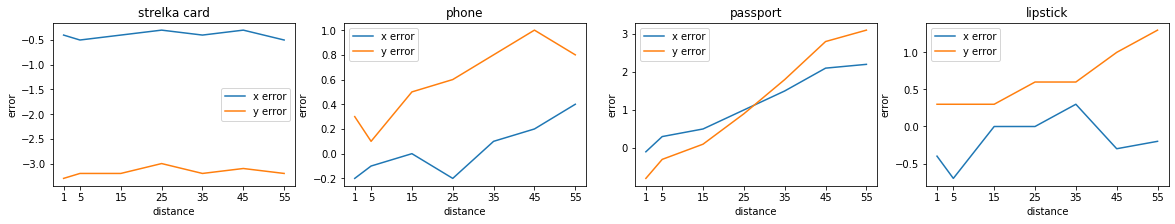

In [79]:
f, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (20, 3))
for i in range(4):
    ax[i].set_title(objects[i])
    ax[i].plot([1, 5, 15, 25, 35, 45, 55], results_x[i], label = 'x error')
    ax[i].plot([1, 5, 15, 25, 35, 45, 55], results_y[i], label = 'y error')
    ax[i].set_ylabel('error')
    ax[i].set_xticks([1, 5, 15, 25, 35, 45, 55])
    ax[i].set_xlabel('distance')
    ax[i].legend()


In [75]:
results

,objects,ground truth,1cm,5cm,15cm,25cm,35cm,45cm,55cm
0,strelka card,"(8.5, 5.5)","(-0.4, -3.3)","(-0.5, -3.2)","(-0.4, -3.2)","(-0.3, -3.0)","(-0.4, -3.2)","(-0.3, -3.1)","(-0.5, -3.2)"
1,phone,"(14, 7.5)","(-0.2, 0.3)","(-0.1, 0.1)","(0.0, 0.5)","(-0.2, 0.6)","(0.1, 0.8)","(0.2, 1.0)","(0.4, 0.8)"
2,passport,"(12.5, 8.5)","(-0.1, -0.8)","(0.3, -0.3)","(0.5, 0.1)","(1.0, 0.9)","(1.5, 1.8)","(2.1, 2.8)","(2.2, 3.1)"
3,lipstick,"(11, 2.4)","(-0.4, 0.3)","(-0.7, 0.3)","(0.0, 0.3)","(0.0, 0.6)","(0.3, 0.6)","(-0.3, 1.0)","(-0.2, 1.3)"


# Possible problems

* When the object has too many bright disconnected detail inside it
* When object is basically white 
* When someone disrupts the countour recognition



<img src="reports/mirror.jpg" style="width: 700px;"/>


<img src="reports/problem_large_contour.jpg" style="width: 700px;"/>

## Start from sample images

In [3]:
files = np.array(os.listdir('data/'))
index = ['.jpg' in i for i in files]
paths = ['data/'+i for i in files[index]]

In [4]:
images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in read_images(paths)]
grayscale_images = [cv2.cvtColor(images[i], cv2.COLOR_RGB2GRAY) for i in range(len(images))]

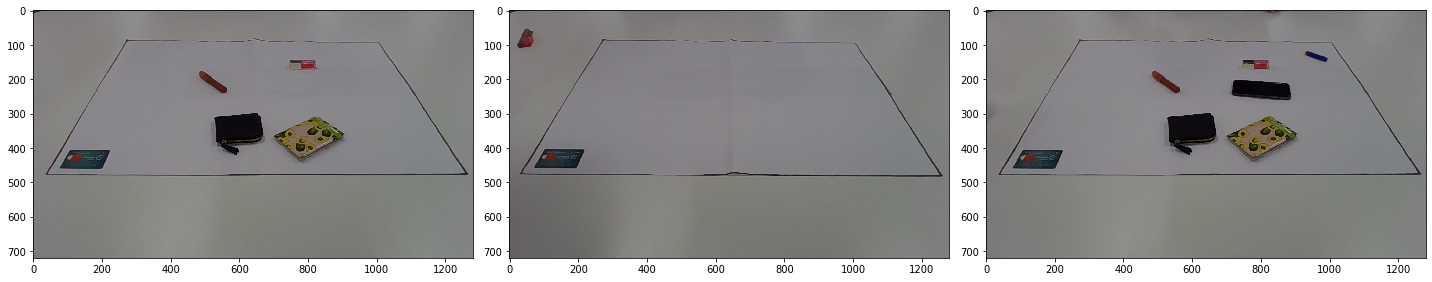

In [5]:
print_images(images, 1, 3)

### Image normalization

In [6]:
n = 3
image_redone, _ = normalize_image(grayscale_images[n], images[n], rescale_param = 0.6)

/Users/polina/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


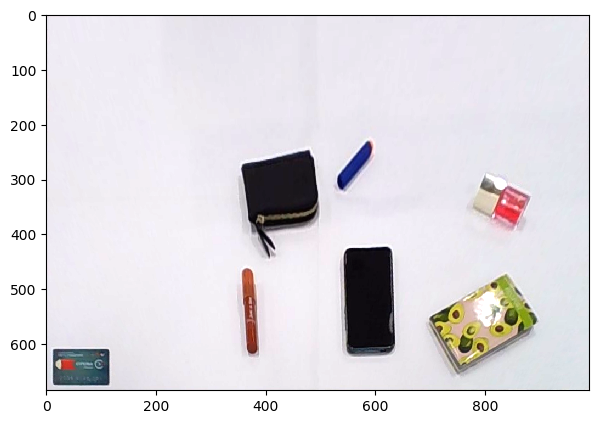

In [7]:
show(image_redone)

### Extraction of internal corners

In [8]:
image_redone, _ = normalize_image(grayscale_images[n], images[n], rescale_param = 0.6)
image = cv2.cvtColor(image_redone, cv2.COLOR_RGB2GRAY)

threshold = skimage.filters.threshold_otsu(image)
predicted = np.uint8(image > 200) * 255

gray = cv2.GaussianBlur(predicted, (7, 7), 0)

edged = cv2.Canny(gray, 50, 100)
edged = cv2.dilate(edged, None, iterations=2)
edged = cv2.erode(edged, None, iterations=1)
 
img, ext_contours, hierarchy = cv2.findContours(edged.copy(),
                                                cv2.RETR_EXTERNAL,
                                                cv2.CHAIN_APPROX_SIMPLE)

(cnts, _) = contours.sort_contours(ext_contours)
cnts = [cnt[:, 0] for cnt in cnts]
pixelsPerMetric = None

result = normalize_image(grayscale_images[n], images[n], rescale_param = 0.6)[0]
for c in cnts:
    if cv2.contourArea(c) < 100:
        continue
    box = cv2.boxPoints(cv2.minAreaRect(c)).astype('int32')
    box = perspective.order_points(box).astype('int32')
    cv2.drawContours(result, [box], -1, (255, 0, 116), 2)

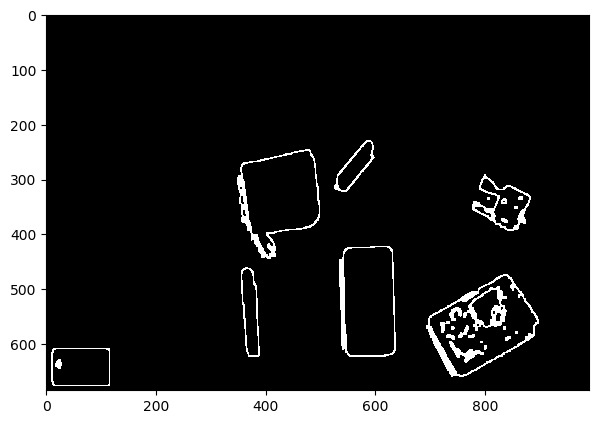

In [9]:
show(img)

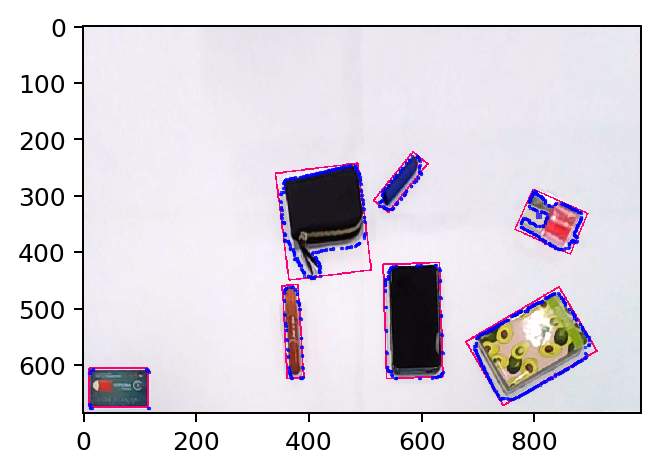

In [10]:
plt.figure(figsize = (4, 4), dpi = 180)
plt.imshow(result)
for i in range(len(cnts)):
    plt.scatter(cnts[i][:, 0], cnts[i][:, 1], c = 'b', s = 0.1)

## Plot boxes on original image and add sizes

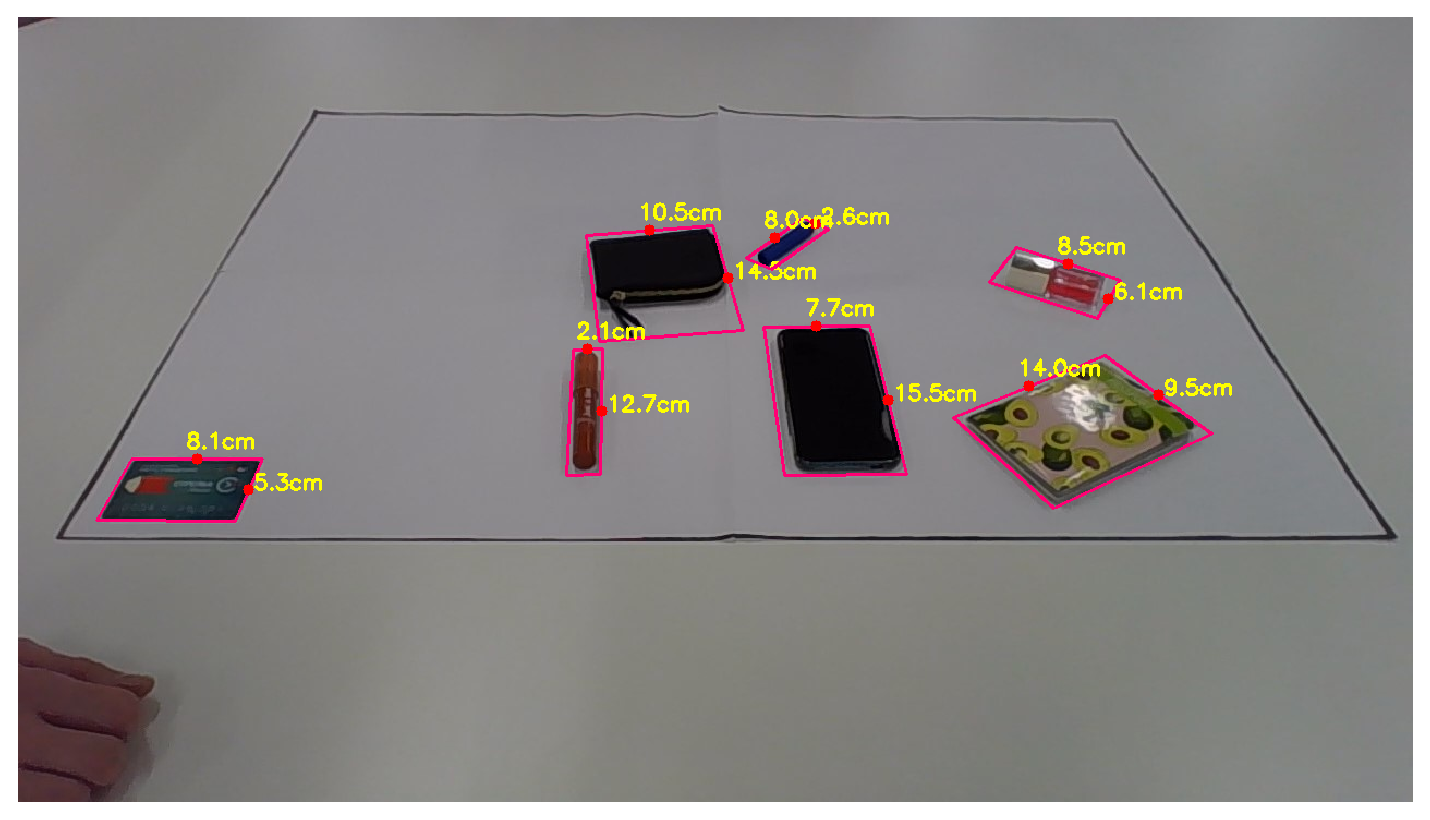

In [21]:
plt.figure(figsize = (10, 10), dpi = 180)
plt.imshow(pipeline(images[3]))
plt.axis('off')
plt.show()

# Apply the algorithm on the sample video

In [3]:
# but this works somehow

video_capture = cv2.VideoCapture('data/video.mp4')
frames = []
for i in tqdm(range(500)):

    ret, frame = video_capture.read()
    frames.append(frame)

video_capture.release()


In [9]:
img_array = []
for frame in tqdm(frames):

#     frame_new = img_as_ubyte(frame)
    frame_new = pipeline(frame)
    if type(frame_new) == type(None):
        frame_new = frame
    
    img_array.append(frame_new)


 [████████████████████████████████████████████████████████████] 500/500 [06:13<00:01, 0.75s/it]

In [10]:
height, width, layers = img_array[0].shape
size = (width,height)

In [11]:
import glob
out = cv2.VideoWriter('project.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()